In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# Thiết lập cấu hình
# plt.style.use('seaborn')
IMG_DIR = 'img'
if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)

# Hàm lưu biểu đồ
def save_plot(filename):
    plt.tight_layout()
    plt.savefig(f'{IMG_DIR}/{filename}', dpi=300)
    # plt.close()

# Hàm vẽ biểu đồ chuỗi thời gian so sánh
def plot_time_series_comparisons(df, columns, titles, filename, figsize=(12, 8)):
    fig, axes = plt.subplots(len(columns), 1, figsize=figsize, sharex=True)
    for i, (col_pair, title) in enumerate(zip(columns, titles)):
        for col, label, color, style in col_pair:
            axes[i].plot(df.index, df[col], label=label, color=color, linestyle=style)
        axes[i].set_title(title)
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True)
    save_plot(filename)

# Hàm phân tích xu hướng và mùa vụ
def analyze_trend_seasonality(series, column_name, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    axes[0].plot(series, label='Original', color='blue')
    axes[1].plot(decomposition.trend, label='Trend', color='orange')
    axes[2].plot(decomposition.seasonal, label='Seasonality', color='green')
    axes[3].plot(decomposition.resid, label='Residual', color='red')
    
    for ax, title in zip(axes, ['Original', 'Trend', 'Seasonality', 'Residual']):
        ax.set_title(f'{column_name} - {title}')
        ax.legend(loc='upper left')
        ax.grid(True)
    
    save_plot(f'{column_name}_decomposition.png')
    
    trend = decomposition.trend.dropna()
    trend_direction = "tăng" if (trend.iloc[-1] - trend.iloc[0]) > 0 else "giảm" if (trend.iloc[-1] - trend.iloc[0]) < 0 else "ổn định"
    seasonality_detected = "có" if decomposition.seasonal.abs().mean() > 0.1 else "không rõ"
    
    return decomposition, trend_direction, seasonality_detected

# Hàm kiểm định tính dừng
def check_stationarity(series, column_name):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f'\nKiểm định ADF cho {column_name}: p-value = {p_value:.4f}')
    
    if p_value < 0.05:
        print(f'{column_name} là chuỗi dừng.')
        return series, 0
    else:
        print(f'{column_name} không dừng. Áp dụng sai phân...')
        diff_series = series.diff().dropna()
        result_diff = adfuller(diff_series)
        p_value_diff = result_diff[1]
        print(f'p-value sau sai phân cấp 1: {p_value_diff:.4f}')
        if p_value_diff < 0.05:
            print(f'{column_name} dừng sau sai phân cấp 1.')
            return diff_series, 1
        else:
            print(f'{column_name} vẫn không dừng.')
            return diff_series, 1

# Hàm phát hiện dị biệt
def detect_anomalies(series, method='zscore', window=12, threshold=2):
    if method == 'zscore':
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        anomalies = (series > (rolling_mean + threshold * rolling_std)) | (series < (rolling_mean - threshold * rolling_std))
    elif method == 'iqr':
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        anomalies = (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))
    return anomalies

# Hàm vẽ biểu đồ dị biệt
def plot_anomalies(df, series_col, anomalies, title, filename):
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[series_col], label=series_col, color='blue')
    plt.plot(df.index[anomalies], df[series_col][anomalies], 'ro', label='Anomalies')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    save_plot(filename)


In [149]:
# Đọc dữ liệu CPI
path_cpi = r"data/cpi.csv"
try:
    df = pd.read_csv(path_cpi)
except FileNotFoundError:
    print(f"File {path_cpi} không tồn tại!")

# Đọc dữ liệu ngoại sinh
path_exog = r"data/exog_data.csv"
try:
    exog_data = pd.read_csv(path_exog, index_col='Ngày', parse_dates=True)
except FileNotFoundError:
    print(f"File {path_exog} không tồn tại! Tạo lãi suất giả lập.")
    exog_data = None

In [150]:
print(df.head(15))
print(exog_data.head(15))

    tg       t    cpi
0    0  Jan-95  103.8
1    1  Feb-95  103.4
2    2  Mar-95  100.2
3    3  Apr-95  101.0
4    4  May-95  101.8
5    5  Jun-95  100.8
6    6  Jul-95  100.0
7    7  Aug-95  100.3
8    8  Sep-95  100.5
9    9  Oct-95  100.1
10  10  Nov-95  100.1
11  11  Dec-95  100.3
12  12  Jan-96  100.9
13  13  Feb-96  102.5
14  14  Mar-96  100.8
            oil_price  gold_price  interest_rate
Ngày                                            
1995-01-01      18.39       377.7            NaN
1995-02-01      18.49       378.3            NaN
1995-03-01      19.17       394.3            NaN
1995-04-01      20.38       388.5            NaN
1995-05-01      18.89       387.6            NaN
1995-06-01      17.40       385.6            NaN
1995-07-01      17.56       388.4            NaN
1995-08-01      17.84       386.9            NaN
1995-09-01      17.54       386.5            NaN
1995-10-01      17.64       384.3            NaN
1995-11-01      18.18       388.6            NaN
1995-12-01 

In [151]:
# Tiền xử lý CPI
df['t'] = pd.to_datetime(df['t'], format='%b-%y')
df.drop(columns=['tg'], inplace=True, errors='ignore')
df.columns = ['time', 'cpi_mom']
df.set_index('time', inplace=True)
df.index.freq = 'MS'

# Xử lý giá trị thiếu trong CPI
print("Giá trị thiếu trong CPI:", df.isnull().sum().to_dict())
df['cpi_mom'] = df['cpi_mom'].interpolate(method='linear')

# Tính CPI YoY
df["cpi_yoy"] = (df["cpi_mom"] / 100).rolling(window=12).apply(np.prod) * 100
df["cpi_yoy"] = df["cpi_yoy"].round(2)
df.dropna(inplace=True)

# Kiểm tra dữ liệu đủ để phân tích
if len(df) < 24:
    print("Dữ liệu quá ngắn (cần ít nhất 24 tháng).")

# Gộp dữ liệu
if exog_data is not None:
    exog_data = exog_data.reindex(df.index, method='nearest')
    merged_df = df.merge(exog_data[['oil_price', 'gold_price', 'interest_rate']], 
                        left_index=True, right_index=True, how='inner')
    print("Giá trị thiếu trong merged_df:", merged_df.isnull().sum().to_dict())
    merged_df[['oil_price', 'gold_price', 'interest_rate']] = merged_df[['oil_price', 'gold_price', 'interest_rate']].interpolate(method='linear')
else:
    # Tạo lãi suất giả lập nếu không có exog_data
    print("Tạo lãi suất giả lập vì không tìm thấy exog_data.")
    np.random.seed(42)
    df['interest_rate'] = 5 + np.random.normal(0, 0.5, len(df))
    merged_df = df.copy()

Giá trị thiếu trong CPI: {'cpi_mom': 0}
Giá trị thiếu trong merged_df: {'cpi_mom': 0, 'cpi_yoy': 0, 'oil_price': 0, 'gold_price': 0, 'interest_rate': 4}


In [152]:
merged_df.head(15)

,cpi_mom,cpi_yoy,oil_price,gold_price,interest_rate
time,,,,,
1995-12-01,100.3,112.91,19.55,388.1,NaN
1996-01-01,100.9,109.76,17.74,408.5,NaN
1996-02-01,102.5,108.80,19.54,401.2,NaN
1996-03-01,100.8,109.46,21.47,398.4,NaN
1996-04-01,100.1,108.48,21.20,393.5,25.410000
1996-05-01,99.5,106.03,19.76,394.4,24.290000
1996-06-01,99.5,104.66,20.92,381.6,23.170000
1996-07-01,99.3,103.93,20.42,393.1,24.680000
1996-08-01,99.6,103.20,22.25,391.3,24.610000



Phân tích cpi_mom:
Xu hướng: giảm
Tính mùa vụ: có

Kiểm định ADF cho cpi_mom: p-value = 0.0028
cpi_mom là chuỗi dừng.

Phân tích cpi_yoy:
Xu hướng: giảm
Tính mùa vụ: không rõ

Kiểm định ADF cho cpi_yoy: p-value = 0.0677
cpi_yoy không dừng. Áp dụng sai phân...
p-value sau sai phân cấp 1: 0.0000
cpi_yoy dừng sau sai phân cấp 1.


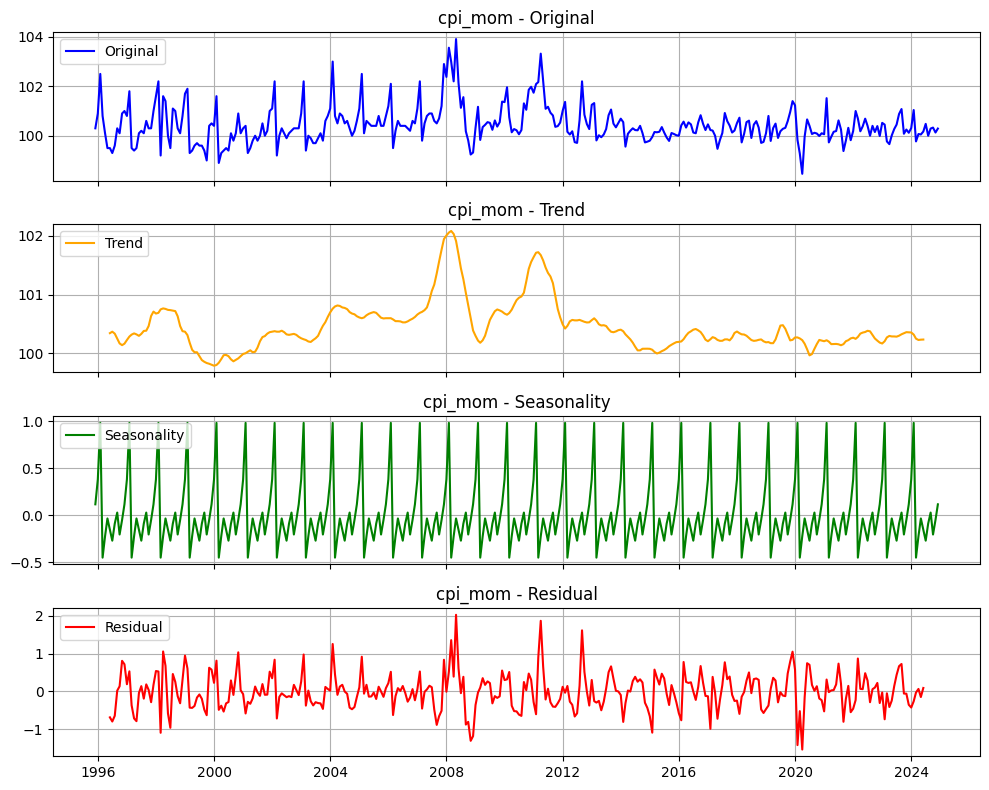

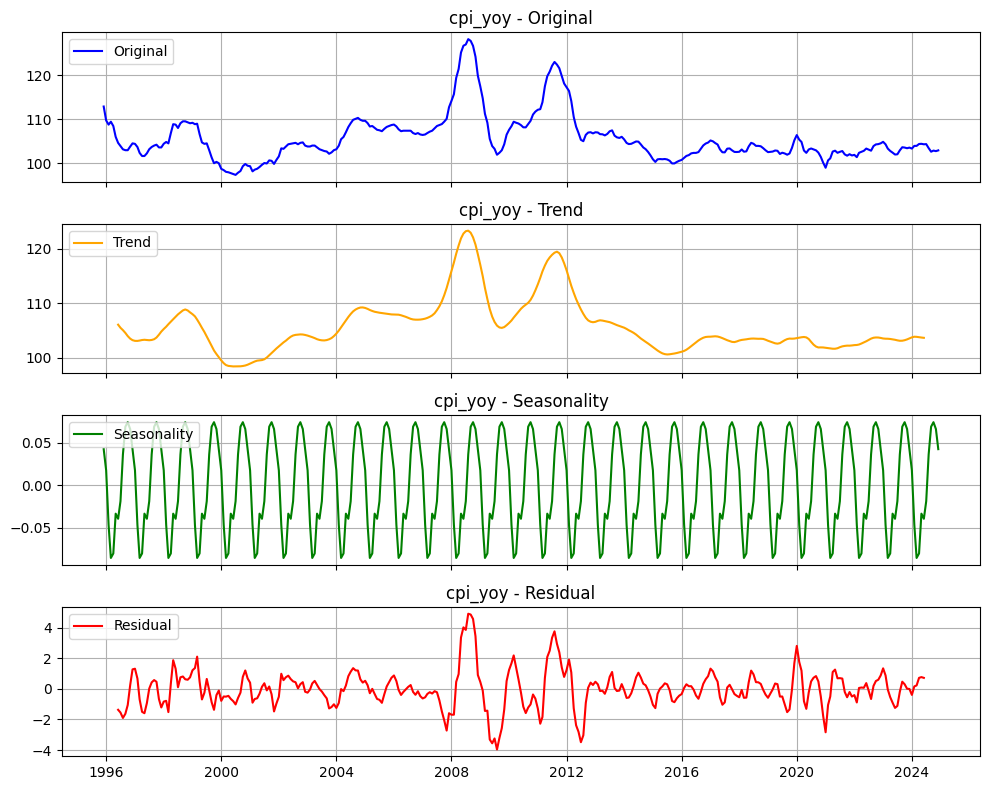

In [153]:
# Làm mượt dữ liệu
window_size = 3
merged_df['cpi_mom_smoothed'] = merged_df['cpi_mom'].rolling(window=window_size, center=True).mean().fillna(merged_df['cpi_mom'])
merged_df['cpi_yoy_smoothed'] = merged_df['cpi_yoy'].rolling(window=window_size, center=True).mean().fillna(merged_df['cpi_yoy'])

# Chuyển đổi log
merged_df['cpi_mom_log'] = np.log(merged_df['cpi_mom'].clip(lower=1e-6))
merged_df['cpi_yoy_log'] = np.log(merged_df['cpi_yoy'].clip(lower=1e-6))

# Tính sai phân
merged_df['cpi_yoy_diff'] = merged_df['cpi_yoy'].diff()

# Thêm cột tháng và năm
merged_df['month'] = merged_df.index.month
merged_df['year'] = merged_df.index.year

# Phân tích đặc tính chuỗi
for col in ['cpi_mom', 'cpi_yoy']:
    print(f"\nPhân tích {col}:")
    decomposition, trend, seasonality = analyze_trend_seasonality(merged_df[col], col)
    print(f'Xu hướng: {trend}')
    print(f'Tính mùa vụ: {seasonality}')
    diff_series, diff_order = check_stationarity(merged_df[col], col)
    merged_df[f'{col}_diff'] = merged_df[col].diff()


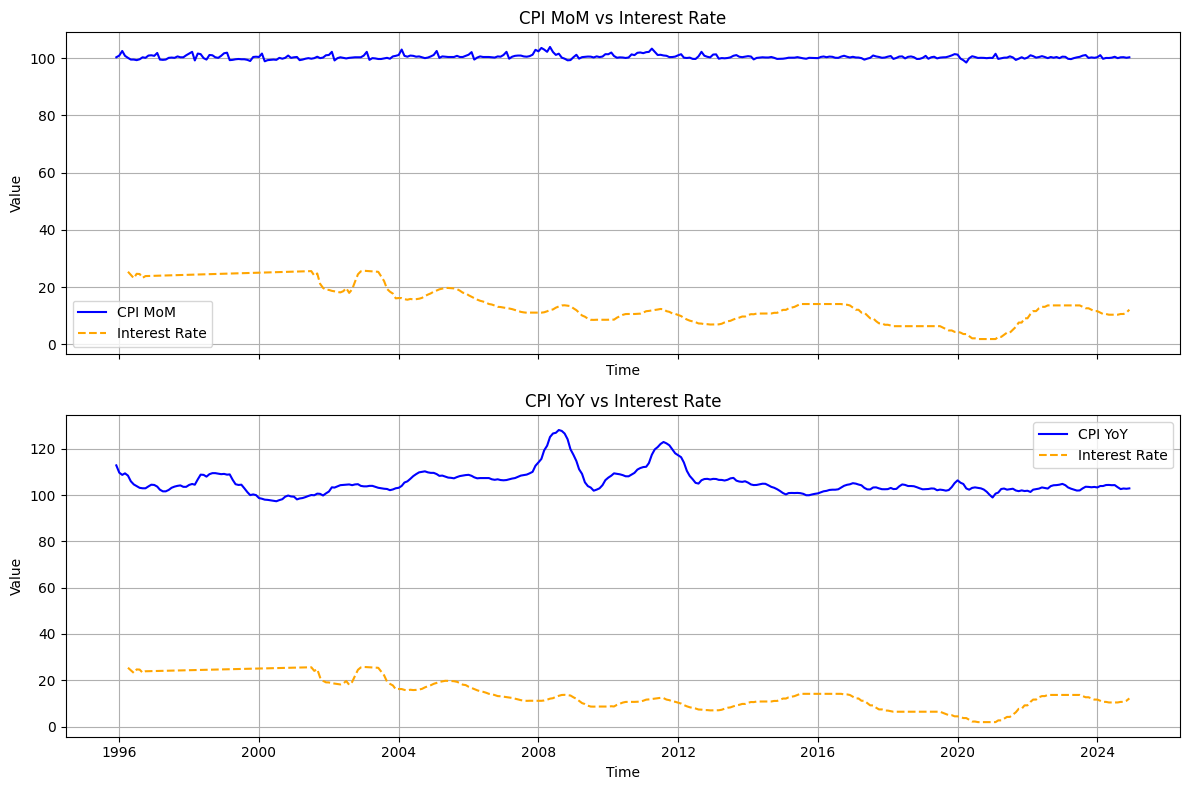

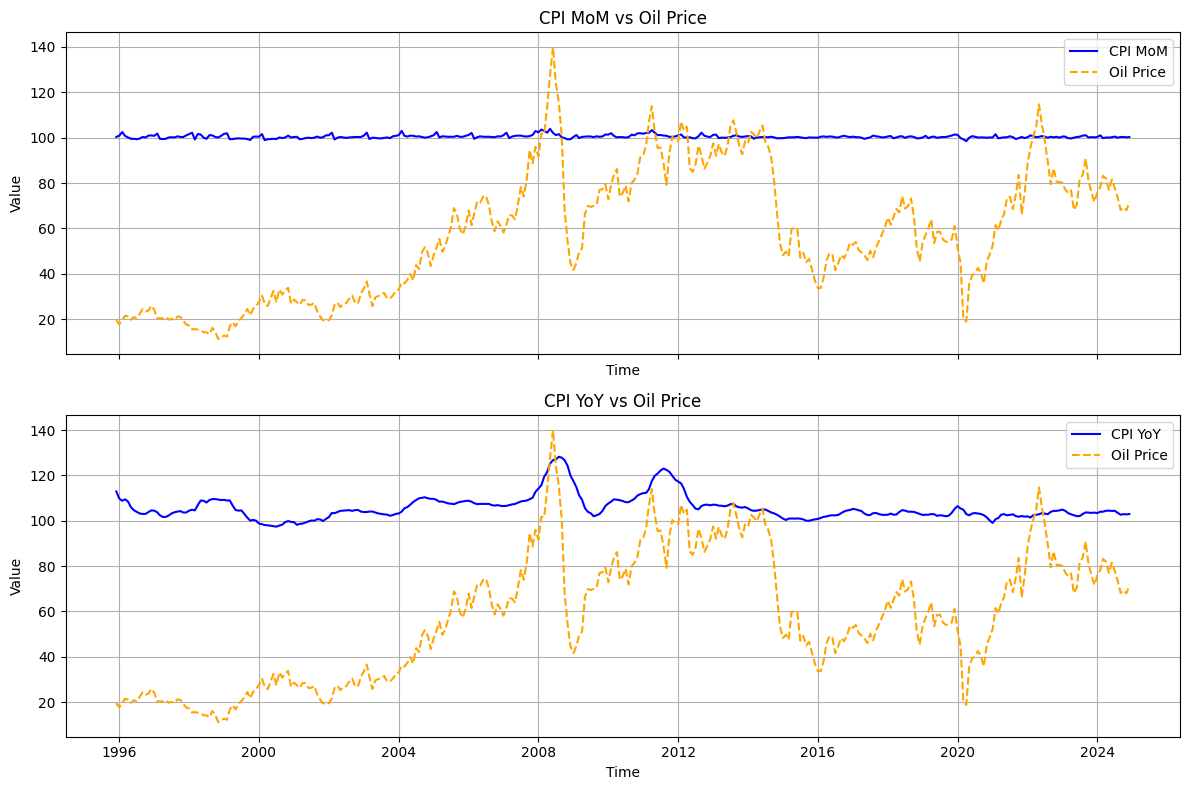

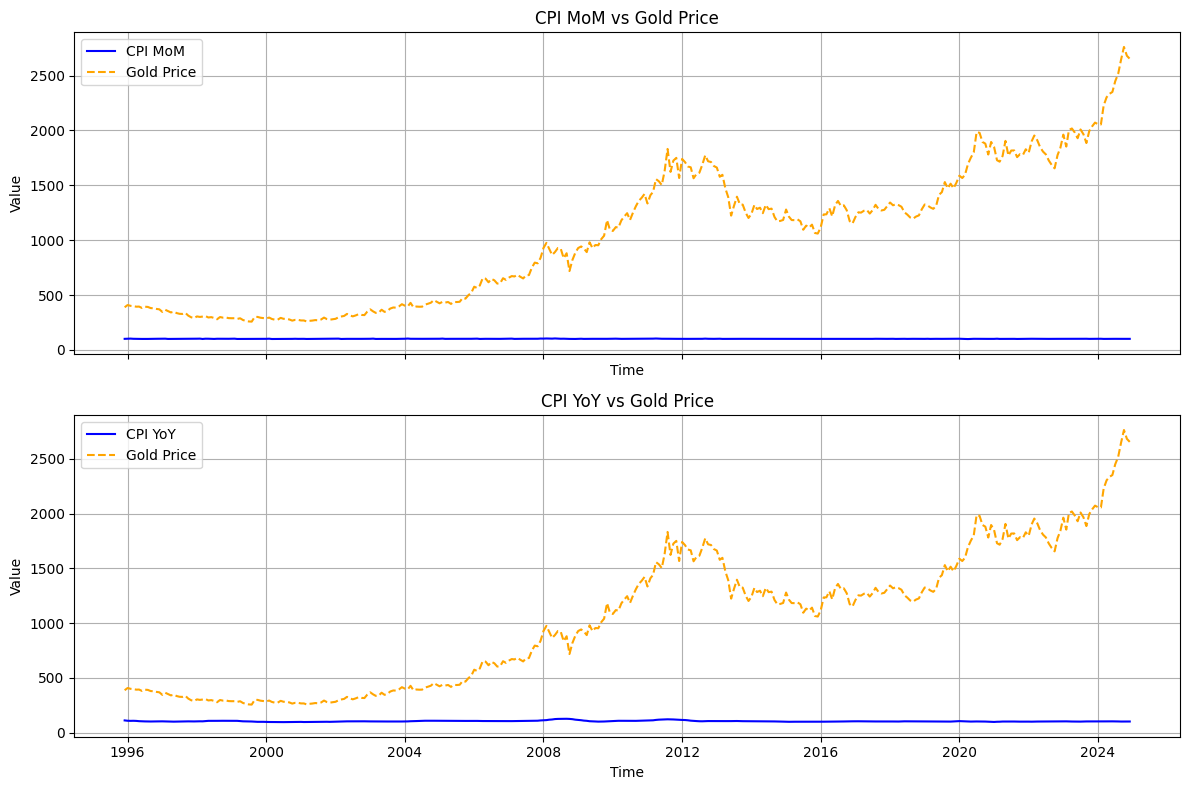

In [154]:
# So sánh với interest_rate
plot_time_series_comparisons(
    merged_df,
    [
        [
            ('cpi_mom', 'CPI MoM', 'blue', '-'),
            ('interest_rate', 'Interest Rate', 'orange', '--')
        ],
        [
            ('cpi_yoy', 'CPI YoY', 'blue', '-'),
            ('interest_rate', 'Interest Rate', 'orange', '--')
        ]
    ],
    ['CPI MoM vs Interest Rate', 'CPI YoY vs Interest Rate'],
    'cpi_vs_interest_rate.png'
)

# So sánh với giá dầu
plot_time_series_comparisons(
    merged_df,
    [
        [
            ('cpi_mom', 'CPI MoM', 'blue', '-'),
            ('oil_price', 'Oil Price', 'orange', '--')
        ],
        [
            ('cpi_yoy', 'CPI YoY', 'blue', '-'),
            ('oil_price', 'Oil Price', 'orange', '--')
        ]
    ],
    ['CPI MoM vs Oil Price', 'CPI YoY vs Oil Price'],
    'cpi_vs_oil_price.png'
)
# So sánh với giá vàng
plot_time_series_comparisons(
    merged_df,
    [
        [
            ('cpi_mom', 'CPI MoM', 'blue', '-'),
            ('gold_price', 'Gold Price', 'orange', '--')
        ],
        [
            ('cpi_yoy', 'CPI YoY', 'blue', '-'),
            ('gold_price', 'Gold Price', 'orange', '--')
        ]
    ],
    ['CPI MoM vs Gold Price', 'CPI YoY vs Gold Price'],
    'cpi_vs_gold_price.png'
)


Tương quan giữa CPI và các biến kinh tế:
                cpi_mom   cpi_yoy
interest_rate -0.101874 -0.129139
oil_price      0.306531  0.438879
gold_price    -0.002401  0.016316


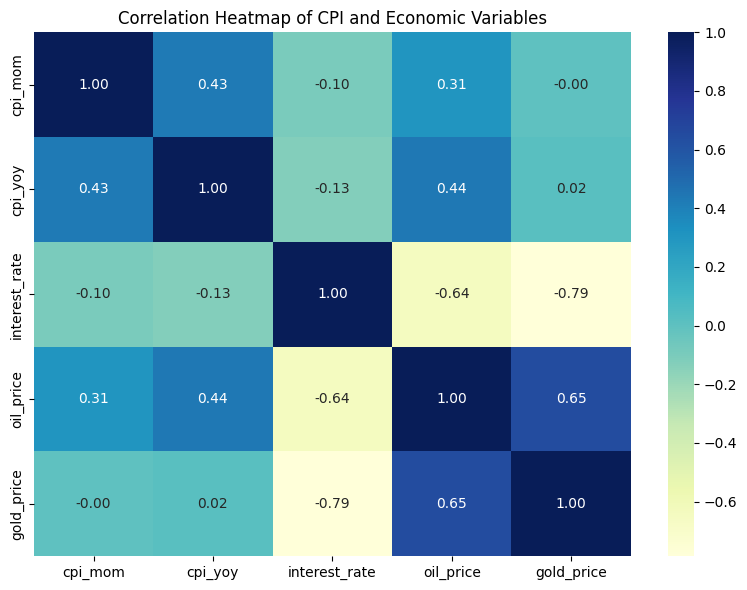

In [155]:
# Phân tích tương quan
print("\nTương quan giữa CPI và các biến kinh tế:")
corr_matrix = merged_df[['cpi_mom', 'cpi_yoy', 'interest_rate', 'oil_price', 'gold_price']].corr()
print(corr_matrix[['cpi_mom', 'cpi_yoy']].loc[['interest_rate', 'oil_price', 'gold_price']])

# Biểu đồ heatmap tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Heatmap of CPI and Economic Variables')
save_plot('cpi_correlation_heatmap.png')


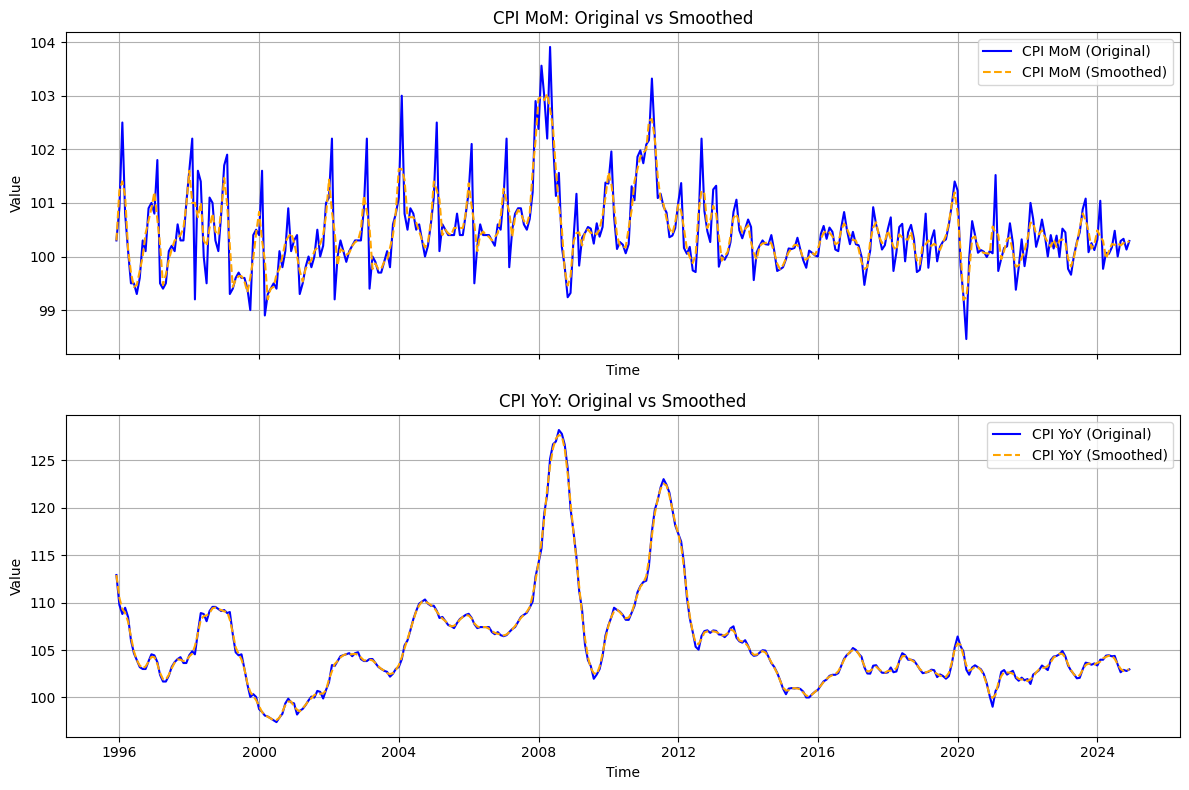

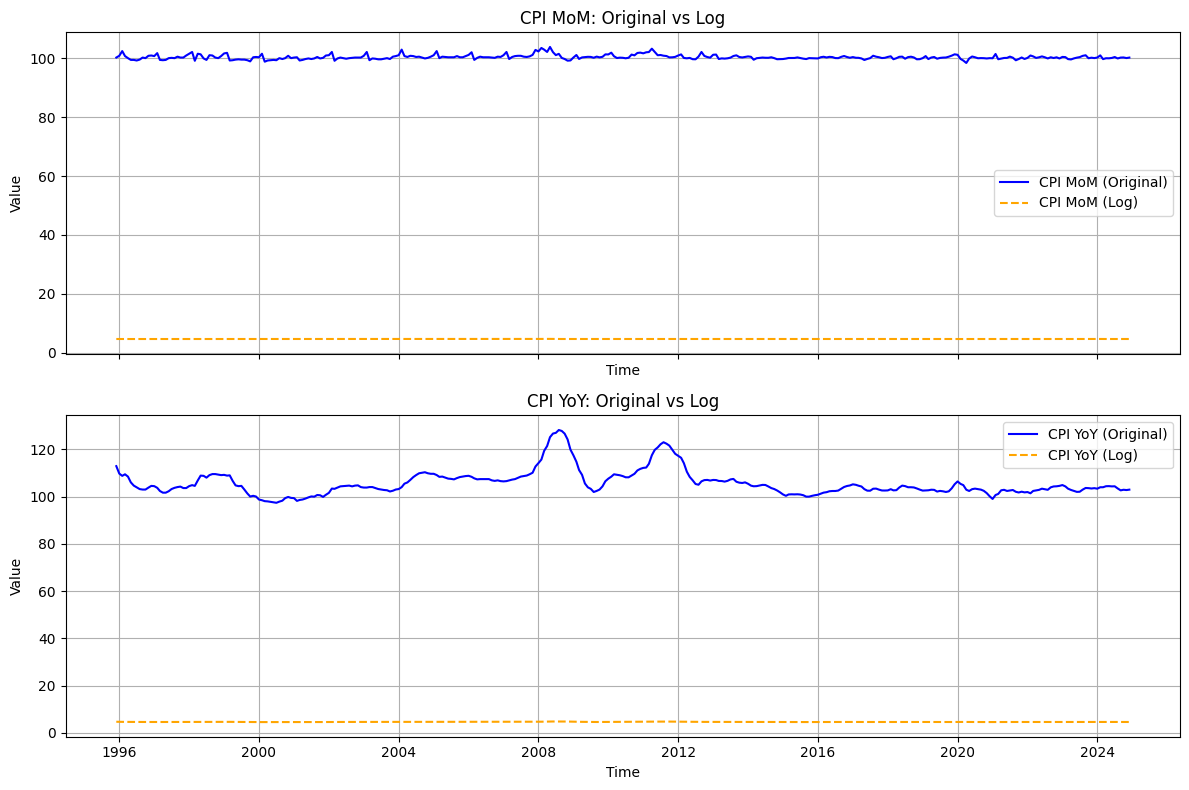

In [156]:
# Biểu đồ so sánh smoothed và log
plot_time_series_comparisons(
    merged_df,
    [
        [
            ('cpi_mom', 'CPI MoM (Original)', 'blue', '-'),
            ('cpi_mom_smoothed', 'CPI MoM (Smoothed)', 'orange', '--')
        ],
        [
            ('cpi_yoy', 'CPI YoY (Original)', 'blue', '-'),
            ('cpi_yoy_smoothed', 'CPI YoY (Smoothed)', 'orange', '--')
        ]
    ],
    ['CPI MoM: Original vs Smoothed', 'CPI YoY: Original vs Smoothed'],
    'cpi_original_vs_smoothed.png'
)

plot_time_series_comparisons(
    merged_df,
    [
        [
            ('cpi_mom', 'CPI MoM (Original)', 'blue', '-'),
            ('cpi_mom_log', 'CPI MoM (Log)', 'orange', '--')
        ],
        [
            ('cpi_yoy', 'CPI YoY (Original)', 'blue', '-'),
            ('cpi_yoy_log', 'CPI YoY (Log)', 'orange', '--')
        ]
    ],
    ['CPI MoM: Original vs Log', 'CPI YoY: Original vs Log'],
    'cpi_original_vs_log.png'
)

2025-05-07 01:45:01,389 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-07 01:45:01,402 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-07 01:45:01,488 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-07 01:45:01,504 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Dữ liệu đã xử lý được lưu vào 'data/analyzed_time_series.csv'.


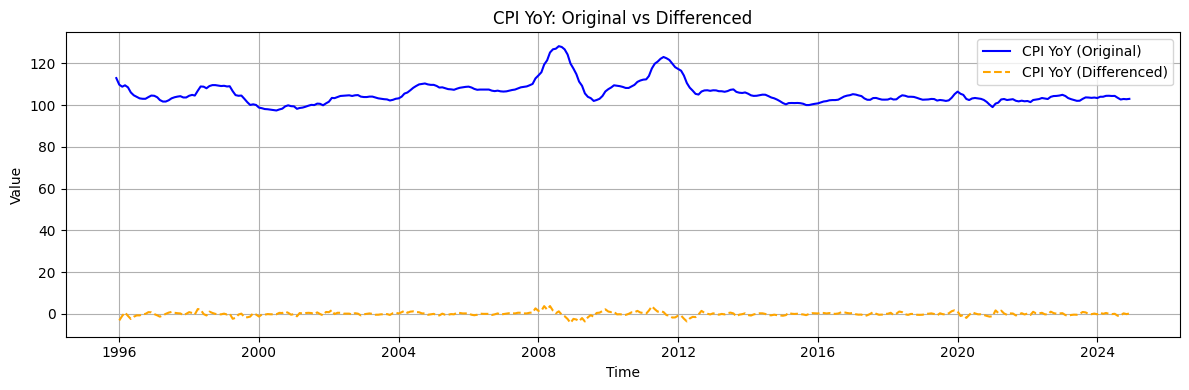

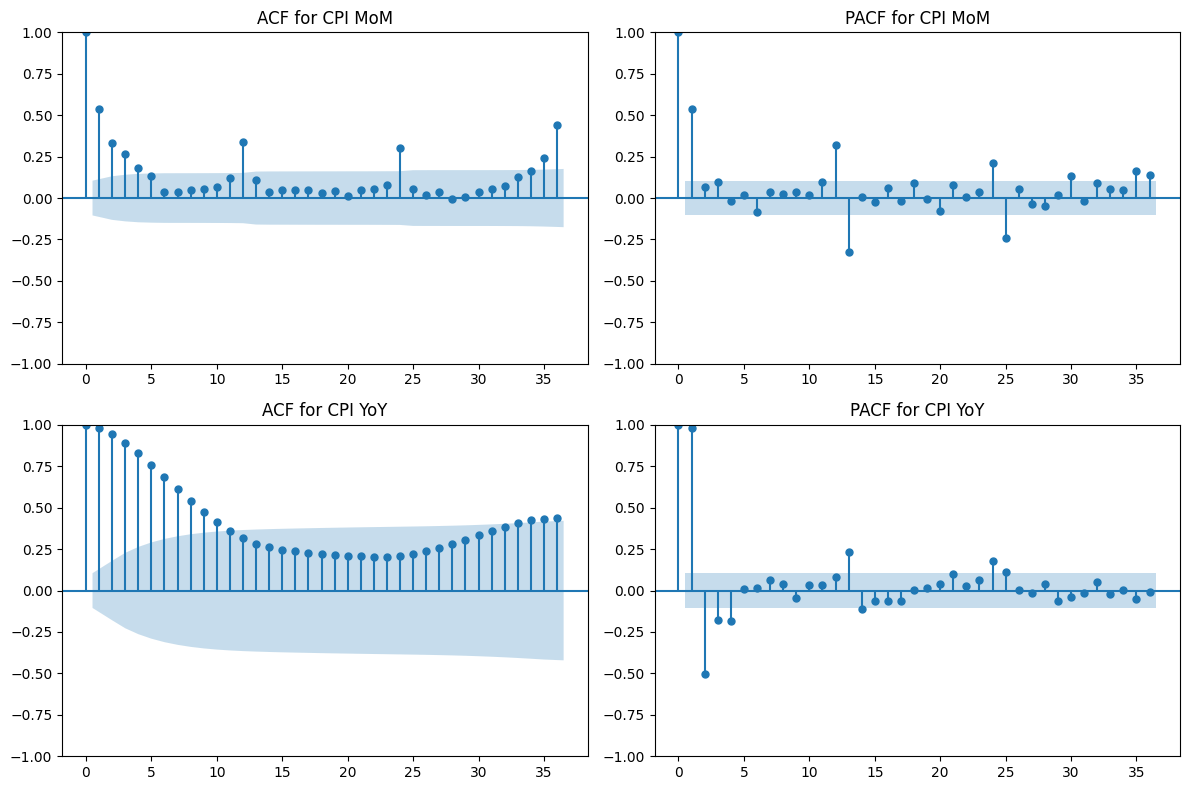

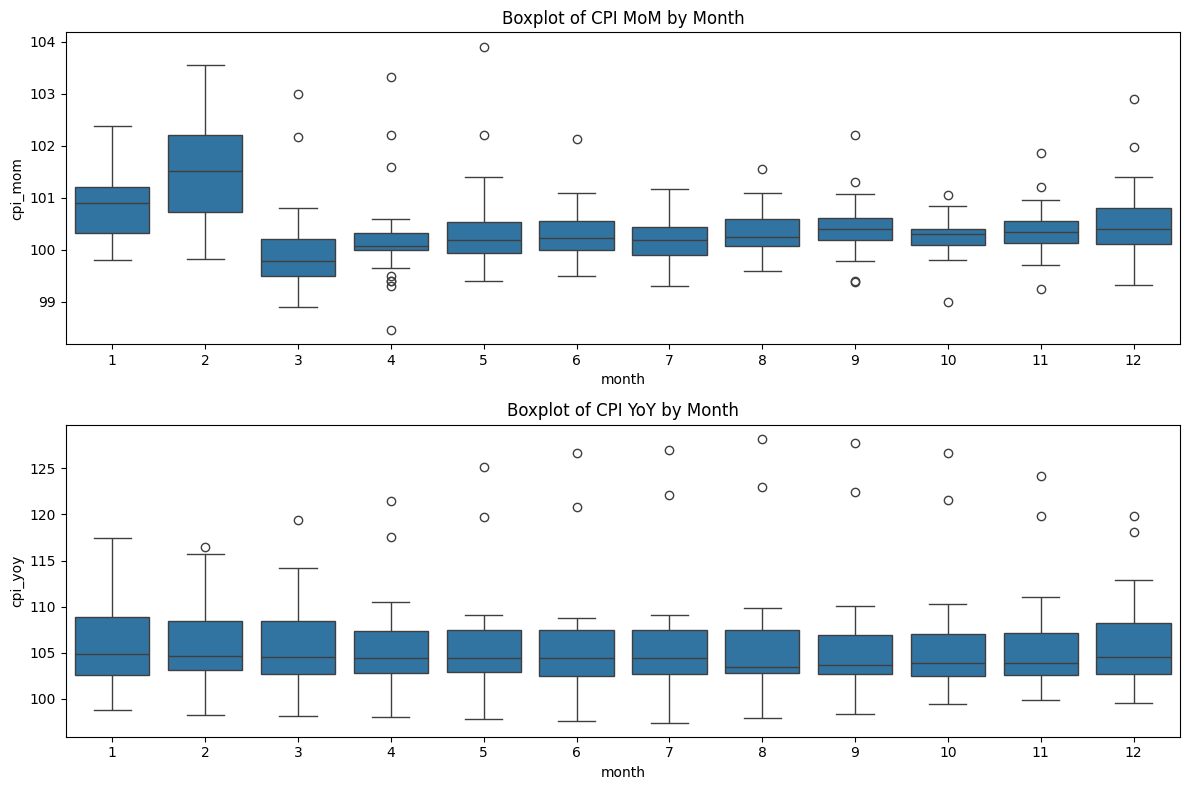

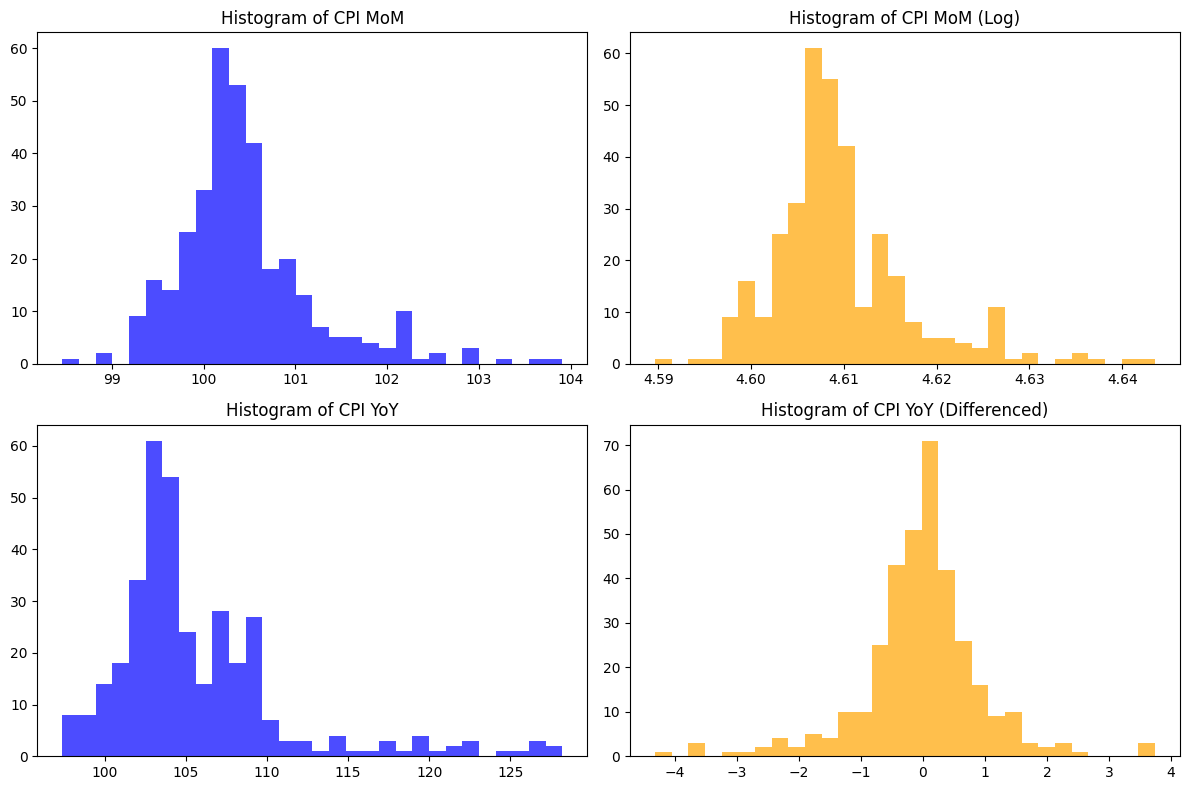

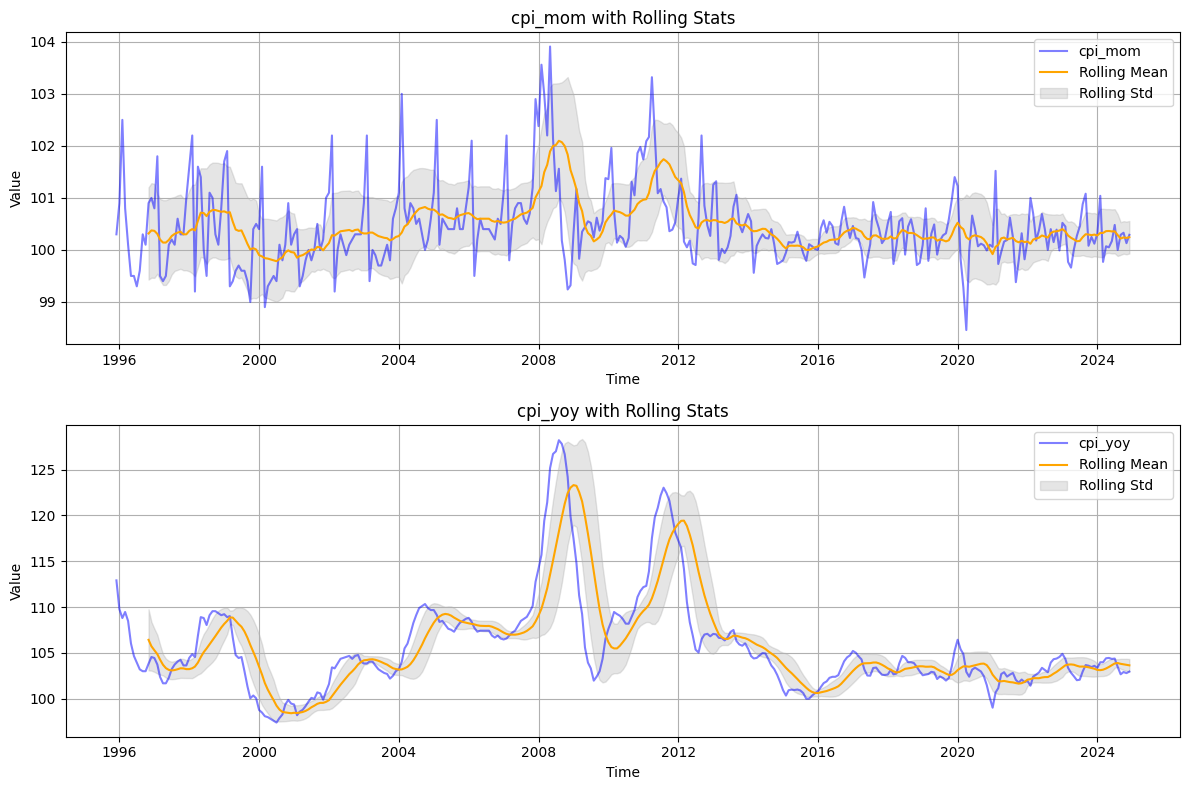

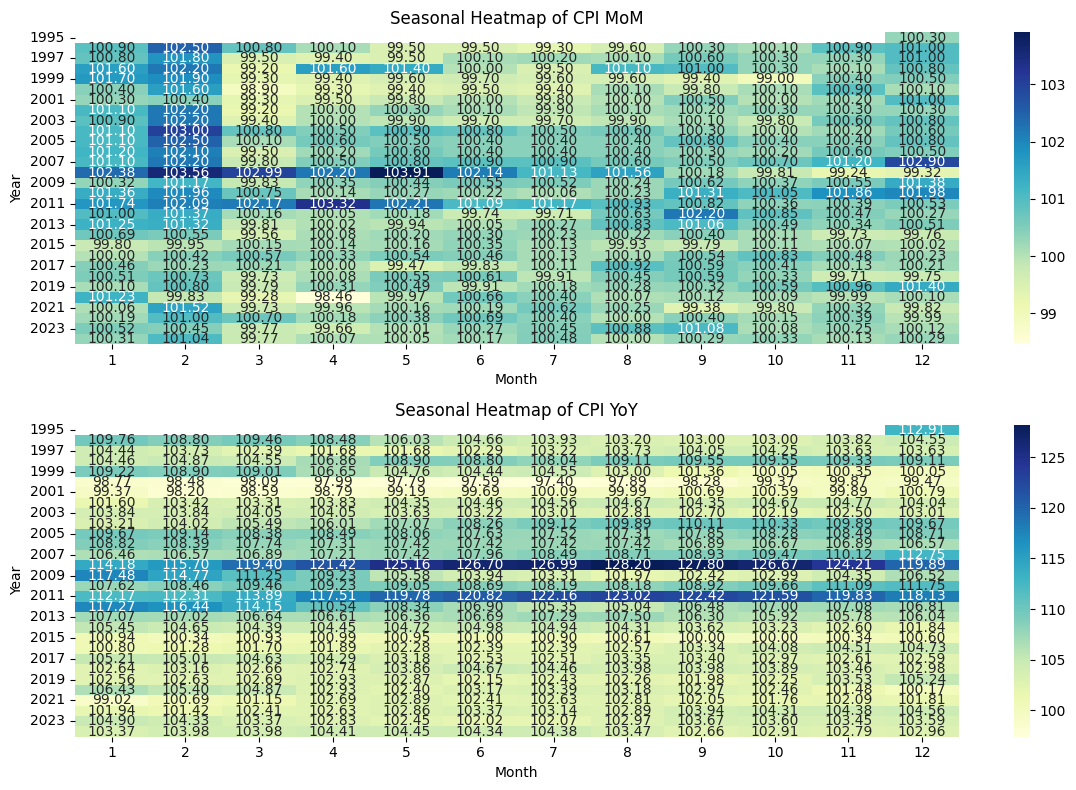

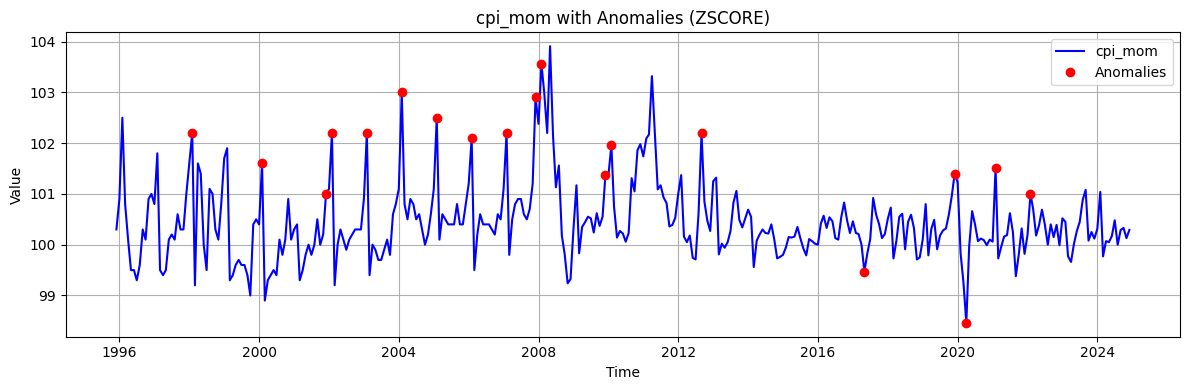

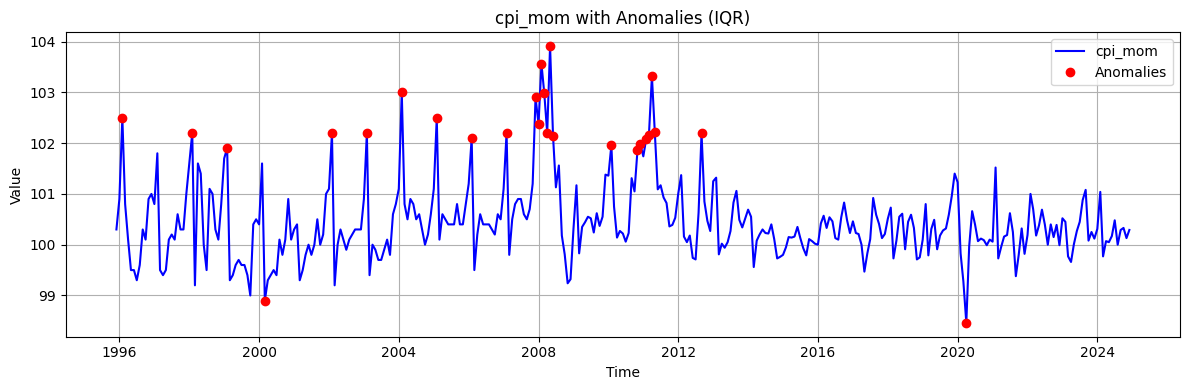

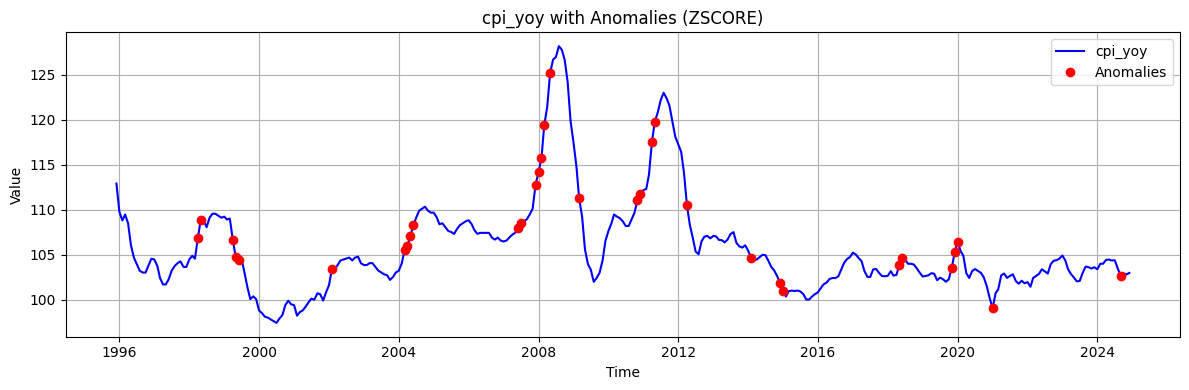

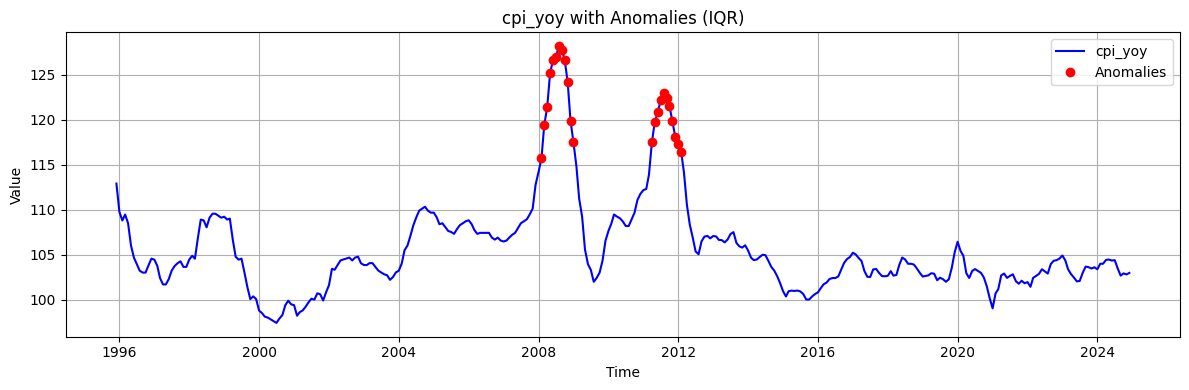

In [157]:


# Biểu đồ sai phân
plt.figure(figsize=(12, 4))
plt.plot(merged_df['cpi_yoy'], label='CPI YoY (Original)', color='blue')
plt.plot(merged_df['cpi_yoy_diff'], label='CPI YoY (Differenced)', color='orange', linestyle='--')
plt.title('CPI YoY: Original vs Differenced')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
save_plot('cpi_yoy_original_vs_diff.png')

# Biểu đồ ACF và PACF
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(merged_df['cpi_mom'].dropna(), lags=36, ax=axes[0, 0], title='ACF for CPI MoM')
plot_pacf(merged_df['cpi_mom'].dropna(), lags=36, ax=axes[0, 1], title='PACF for CPI MoM')
plot_acf(merged_df['cpi_yoy'].dropna(), lags=36, ax=axes[1, 0], title='ACF for CPI YoY')
plot_pacf(merged_df['cpi_yoy'].dropna(), lags=36, ax=axes[1, 1], title='PACF for CPI YoY')
save_plot('cpi_acf_pacf_plots.png')

# Boxplot theo tháng
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sns.boxplot(x='month', y='cpi_mom', data=merged_df, ax=axes[0])
axes[0].set_title('Boxplot of CPI MoM by Month')
sns.boxplot(x='month', y='cpi_yoy', data=merged_df, ax=axes[1])
axes[1].set_title('Boxplot of CPI YoY by Month')
save_plot('cpi_boxplot_by_month.png')

# Histogram
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].hist(merged_df['cpi_mom'].dropna(), bins=30, color='blue', alpha=0.7)
axes[0, 0].set_title('Histogram of CPI MoM')
axes[0, 1].hist(merged_df['cpi_mom_log'].dropna(), bins=30, color='orange', alpha=0.7)
axes[0, 1].set_title('Histogram of CPI MoM (Log)')
axes[1, 0].hist(merged_df['cpi_yoy'].dropna(), bins=30, color='blue', alpha=0.7)
axes[1, 0].set_title('Histogram of CPI YoY')
axes[1, 1].hist(merged_df['cpi_yoy_diff'].dropna(), bins=30, color='orange', alpha=0.7)
axes[1, 1].set_title('Histogram of CPI YoY (Differenced)')
save_plot('cpi_histogram.png')

# Rolling stats
window = 12
for col in ['cpi_mom', 'cpi_yoy']:
    merged_df[f'{col}_rolling_mean'] = merged_df[col].rolling(window=window).mean()
    merged_df[f'{col}_rolling_std'] = merged_df[col].rolling(window=window).std()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
for i, col in enumerate(['cpi_mom', 'cpi_yoy']):
    axes[i].plot(merged_df[col], label=col, color='blue', alpha=0.5)
    axes[i].plot(merged_df[f'{col}_rolling_mean'], label='Rolling Mean', color='orange')
    axes[i].fill_between(merged_df.index, 
                        merged_df[f'{col}_rolling_mean'] - merged_df[f'{col}_rolling_std'], 
                        merged_df[f'{col}_rolling_mean'] + merged_df[f'{col}_rolling_std'], 
                        color='gray', alpha=0.2, label='Rolling Std')
    axes[i].set_title(f'{col} with Rolling Stats')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True)
save_plot('cpi_rolling_stats.png')

# Heatmap mùa vụ
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
for i, (col, title) in enumerate([('cpi_mom', 'CPI MoM'), ('cpi_yoy', 'CPI YoY')]):
    pivot = merged_df.pivot_table(values=col, index='year', columns='month', aggfunc='mean')
    sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='.2f', ax=axes[i])
    axes[i].set_title(f'Seasonal Heatmap of {title}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Year')
save_plot('cpi_seasonal_heatmap.png')

# Phát hiện dị biệt
for col in ['cpi_mom', 'cpi_yoy']:
    for method, suffix in [('zscore', 'zscore'), ('iqr', 'iqr')]:
        anomalies = detect_anomalies(merged_df[col], method=method)
        plot_anomalies(merged_df, col, anomalies, f'{col} with Anomalies ({method.upper()})',
                        f'{col}_anomalies_{suffix}.png')

# Lưu dữ liệu
merged_df.to_csv('data/analyzed_time_series.csv')
print("\nDữ liệu đã xử lý được lưu vào 'data/analyzed_time_series.csv'.")

